In [2]:
import tensorflow as tf
import numpy as np 
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt

In [33]:
mnist_base_path="/Users/zhouwencheng/Desktop/Grass/data/picture/mnist"
# 载入数据集
mnist = input_data.read_data_sets(mnist_base_path, one_hot=True)

Extracting ./data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [88]:
class DA(object):
    def __init__(self, n_input = 784, n_hid_1 = 128, n_hid_2 = 64, activetor_func = tf.nn.sigmoid):
        self.n_input = n_input
        self.n_hid_1 = n_hid_1
        self.n_hid_2 = n_hid_2
        self.activetor_func = activetor_func
        
        self.w_encode_1 = self.__get_w_variable(n_input, n_hid_1)
        self.w_encode_2 = self.__get_w_variable(n_hid_1, n_hid_2)
        self.b_encode_1  = self.__get_b_variable(n_hid_1)
        self.b_encode_2 = self.__get_b_variable(n_hid_2)
        
        self.w_decode_1 = self.__get_w_variable(n_hid_2, n_hid_1)
        self.w_decode_2 = self.__get_w_variable(n_hid_1, n_input)
        self.b_decode_1  = self.__get_b_variable(n_hid_1)
        self.b_decode_2  = self.__get_b_variable(n_input)
        
        
    def __get_w_variable(self, in_size, out_size):
        return tf.Variable(tf.truncated_normal(shape = [in_size, out_size], stddev = 0.1))
    
    def __get_b_variable(self, out_size):
        return tf.Variable(tf.constant(0.1, shape = [out_size]))
    
        
    def __add_fc_layer(self, x, W, b, activator_func = None): 
        mul = tf.matmul(x, W) + b
        if activator_func:
            return activator_func(mul)
        else:
            return mul 
        
    def __encode(self, x):
        layer_1 = self.__add_fc_layer(x, self.w_encode_1, self.b_encode_1, tf.nn.sigmoid)
        layer_2 = self.__add_fc_layer(layer_1, self.w_encode_2, self.b_encode_2, tf.nn.sigmoid) 
        return layer_2
    
    def __decode(self, x):
        layer_1 = self.__add_fc_layer(x, self.w_decode_1, self.b_decode_1, tf.nn.sigmoid)
        layer_2 = self.__add_fc_layer(layer_1, self.w_decode_2, self.b_decode_2, tf.nn.sigmoid) 
        return layer_2
    
    def loss(self, x):
        encode = self.__encode(x)
        decond = self.__decode(encode)
        loss = tf.reduce_mean(tf.pow(decond - x, 2))
        return loss
    
    def prediction(self, x):
        encode = self.__encode(x)
        decond = self.__decode(encode)
        return decond
    
    def paramters(self):
        return [self.w_decode_1,  self.w_encode_2, self.b_encode_1, self.b_encode_2,
                  self.w_decode_1,  self.w_decode_2, self.b_decode_1, self.b_decode_2]

In [84]:
# Parameter
learning_rate = 0.01
training_epochs = 15 # 五组训练
batch_size = 256
display_step = 1
examples_to_show = 10

keep_prob = 1

# Network Parameters
n_input = 784  # MNIST data input (img shape: 28*28)

In [85]:
x = tf.placeholder(dtype=tf.float32, shape=[None, 28*28])   

In [86]:
da = DA()
cost = da.loss(x)

y_pred = da.prediction(x)
# Define loss and optimizer, minimize the squared error
# cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
# cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

Epoch: 0001 cost= 0.047778632
Epoch: 0002 cost= 0.031910852
Epoch: 0003 cost= 0.022981299
Epoch: 0004 cost= 0.017555360
Epoch: 0005 cost= 0.015819369
Epoch: 0006 cost= 0.014729501
Epoch: 0007 cost= 0.012549479
Epoch: 0008 cost= 0.013085406
Epoch: 0009 cost= 0.011626001
Epoch: 0010 cost= 0.011149915
Epoch: 0011 cost= 0.010111382
Epoch: 0012 cost= 0.009756357
Epoch: 0013 cost= 0.009206863
Epoch: 0014 cost= 0.008331576
Epoch: 0015 cost= 0.008716340
Optimization Finished!


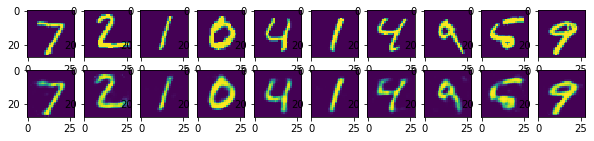

In [87]:
# Launch the graph
with tf.Session() as sess:
    # tf 马上就要废弃tf.initialize_all_variables()这种写法
    # 替换成下面:
    sess.run(tf.global_variables_initializer())
    total_batch = int(mnist.train.num_examples/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)  # max(x) = 1, min(x) = 0 
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_xs})
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c))

    print("Optimization Finished!")
    
    # # Applying encode and decode over test set
    encode_decode = sess.run(
        y_pred, feed_dict={x: mnist.test.images[:examples_to_show]})
    # Compare original images with their reconstructions
    f, a = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(examples_to_show):
        a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
        a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))
    plt.show()